In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import collections
import math
import random
import jieba
import numpy as np
import pandas as pd
from six.moves import xrange
import tensorflow as tf

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import os, os.path
os.chdir('../')

In [4]:
import pandas as pd

In [17]:
# 读取文本，预处理，分词，得到词典
data = pd.read_csv('data/processed_data.csv')
text1 = list(data['text1'])
text2 = list(data['text2'])
assert len(text1) == len(text2)
texts = text1 + text2

added_words = ['花呗','借呗','怎么','什么','我的']
for i in added_words:
    jieba.add_word(i)
    
raw_word_list = []
for text in texts:
    raw_words = list(jieba.cut(text,cut_all=False))
    raw_word_list.extend(raw_words)

In [29]:
os.chdir('word2vec/')

In [18]:
print('# Words after extraction: ', len(raw_word_list))

# Words after extraction:  624056


In [19]:
# Build the dictionary and replace rare words with UNK token.
vocabulary_size = 5000 # Maximum 5K vocabularies
def build_dataset(words):
    count = [['UNK', -1]]
    count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
    print("Count of words: ",len(count))
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    data = list()
    unk_count = 0
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0  
            unk_count += 1
        data.append(index)
    count[0][1] = unk_count
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(raw_word_list)

Count of words:  5000


In [20]:
del raw_word_list
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10], [reverse_dictionary[i] for i in data[:10]])

Most common words (+UNK) [['UNK', 3264], ('花呗', 57167), ('借呗', 23715), ('*', 18365), ('了', 18152)]
Sample data [4382, 10, 232, 1, 218, 105, 148, 32, 1, 5] ['\ufeff', '怎么', '更改', '花呗', '手机号码', '也', '开', '不了', '花呗', '，']


In [21]:
data_index = 0
# Step 3: Function to generate a training batch for the skip-gram model.
def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1  # [ skip_window target skip_window ]
    buffer = collections.deque(maxlen=span)  # Set the max size of the deque with span
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    for i in range(batch_size // num_skips):
        target = skip_window  # target label at the center of the buffer
        targets_to_avoid = [skip_window]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    return batch, labels

batch, labels = generate_batch(batch_size=8, num_skips=2, skip_window=1)
for i in range(8):
    print(batch[i], reverse_dictionary[batch[i]],'->', labels[i, 0], reverse_dictionary[labels[i, 0]])


10 怎么 -> 232 更改
10 怎么 -> 4382 ﻿
232 更改 -> 1 花呗
232 更改 -> 10 怎么
1 花呗 -> 232 更改
1 花呗 -> 218 手机号码
218 手机号码 -> 105 也
218 手机号码 -> 1 花呗


In [25]:
# Step 4: Build and train a skip-gram model.
batch_size = 128
embedding_size = 128  
skip_window = 1       
num_skips = 2         
valid_size = 3      #切记这个数字要和len(valid_word)对应，要不然会报错哦   
valid_window = 100  
num_sampled = 64    # Number of negative examples to sample.
#验证集
valid_word = ['借呗','花呗', '手机号码']
valid_examples =[dictionary[li] for li in valid_word]
graph = tf.Graph()

In [26]:
with graph.as_default():
    # Input data.
    train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

    # Ops and variables pinned to the CPU because of missing GPU implementation
    with tf.device('/cpu:0'):
        # Look up embeddings for inputs.
        embeddings = tf.Variable(
            tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
        embed = tf.nn.embedding_lookup(embeddings, train_inputs)

        # Construct the variables for the NCE loss
        nce_weights = tf.Variable(
            tf.truncated_normal([vocabulary_size, embedding_size],
                                stddev=1.0 / math.sqrt(embedding_size)))
        nce_biases = tf.Variable(tf.zeros([vocabulary_size]),dtype=tf.float32)

    # Compute the average NCE loss for the batch.
    # tf.nce_loss automatically draws a new sample of the negative labels each
    # time we evaluate the loss.
    loss = tf.reduce_mean(
            tf.nn.nce_loss(weights=nce_weights,biases=nce_biases, inputs=embed, labels=train_labels,
                 num_sampled=num_sampled, num_classes=vocabulary_size))

    # Construct the SGD optimizer using a learning rate of 1.0.
    optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)

    # Compute the cosine similarity between minibatch examples and all embeddings.
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
    similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)

    # Add variable initializer.
    init = tf.global_variables_initializer()

In [27]:
# Step 5: Begin training.
num_steps = 100000
with tf.Session(graph=graph) as session:
    # We must initialize all variables before we use them.
    init.run()
    print("Initialized")

    average_loss = 0
    for step in xrange(num_steps):
        batch_inputs, batch_labels = generate_batch(batch_size, num_skips, skip_window)
        feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}

        # We perform one update step by evaluating the optimizer op (including it
        # in the list of returned values for session.run()
        _, loss_val = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += loss_val

        if step % 2000 == 0:
            if step > 0:
                average_loss /= 2000
            # The average loss is an estimate of the loss over the last 2000 batches.
            print("Average loss at step ", step, ": ", average_loss)
            average_loss = 0

        # Note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % 10000 == 0:
            sim = similarity.eval()
            for i in xrange(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8  # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[:top_k]
                log_str = "Nearest to %s:" % valid_word
                for k in xrange(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log_str = "%s %s," % (log_str, close_word)
                print(log_str)
    final_embeddings = normalized_embeddings.eval()


Initialized
Average loss at step  0 :  222.2489776611328
Nearest to 借呗: 借呗, 码后, 我刷, 失败, 何原因, pos, 除了, 旅游,
Nearest to 花呗: 花呗, 增加, 用刷, 单个, 不得, 入住, 已付, 卡通,
Nearest to 手机号码: 手机号码, 周期, 津贴, 多期, 出钱, 发消息, 意外, 工,
Average loss at step  2000 :  21.26264039301872
Average loss at step  4000 :  5.255946158528328
Average loss at step  6000 :  4.782322181105614
Average loss at step  8000 :  4.55834948027134
Average loss at step  10000 :  4.486025141000748
Nearest to 借呗: 借呗, 花呗, ", 】, —, 【, 刮, 变,
Nearest to 花呗: 花呗, 借呗, ", 】, —, ，, 不足, 增加,
Nearest to 手机号码: 手机号码, 【, 津贴, 周期, 账户, 还款, 查, 花呗,
Average loss at step  12000 :  4.369780619025231
Average loss at step  14000 :  4.288625643134117
Average loss at step  16000 :  4.272628340125084
Average loss at step  18000 :  4.266392068982125
Average loss at step  20000 :  4.2509918217659
Nearest to 借呗: 借呗, 花呗, ", 】, 刮, 几千, 电脑操作, 我,
Nearest to 花呗: 花呗, 借呗, ", 】, —, ，, 为什么, 一号,
Nearest to 手机号码: 手机号码, 【, 号码, 账户, 津贴, 周期, 意外, 前两天,
Average loss at step  22000 :  4.2320979

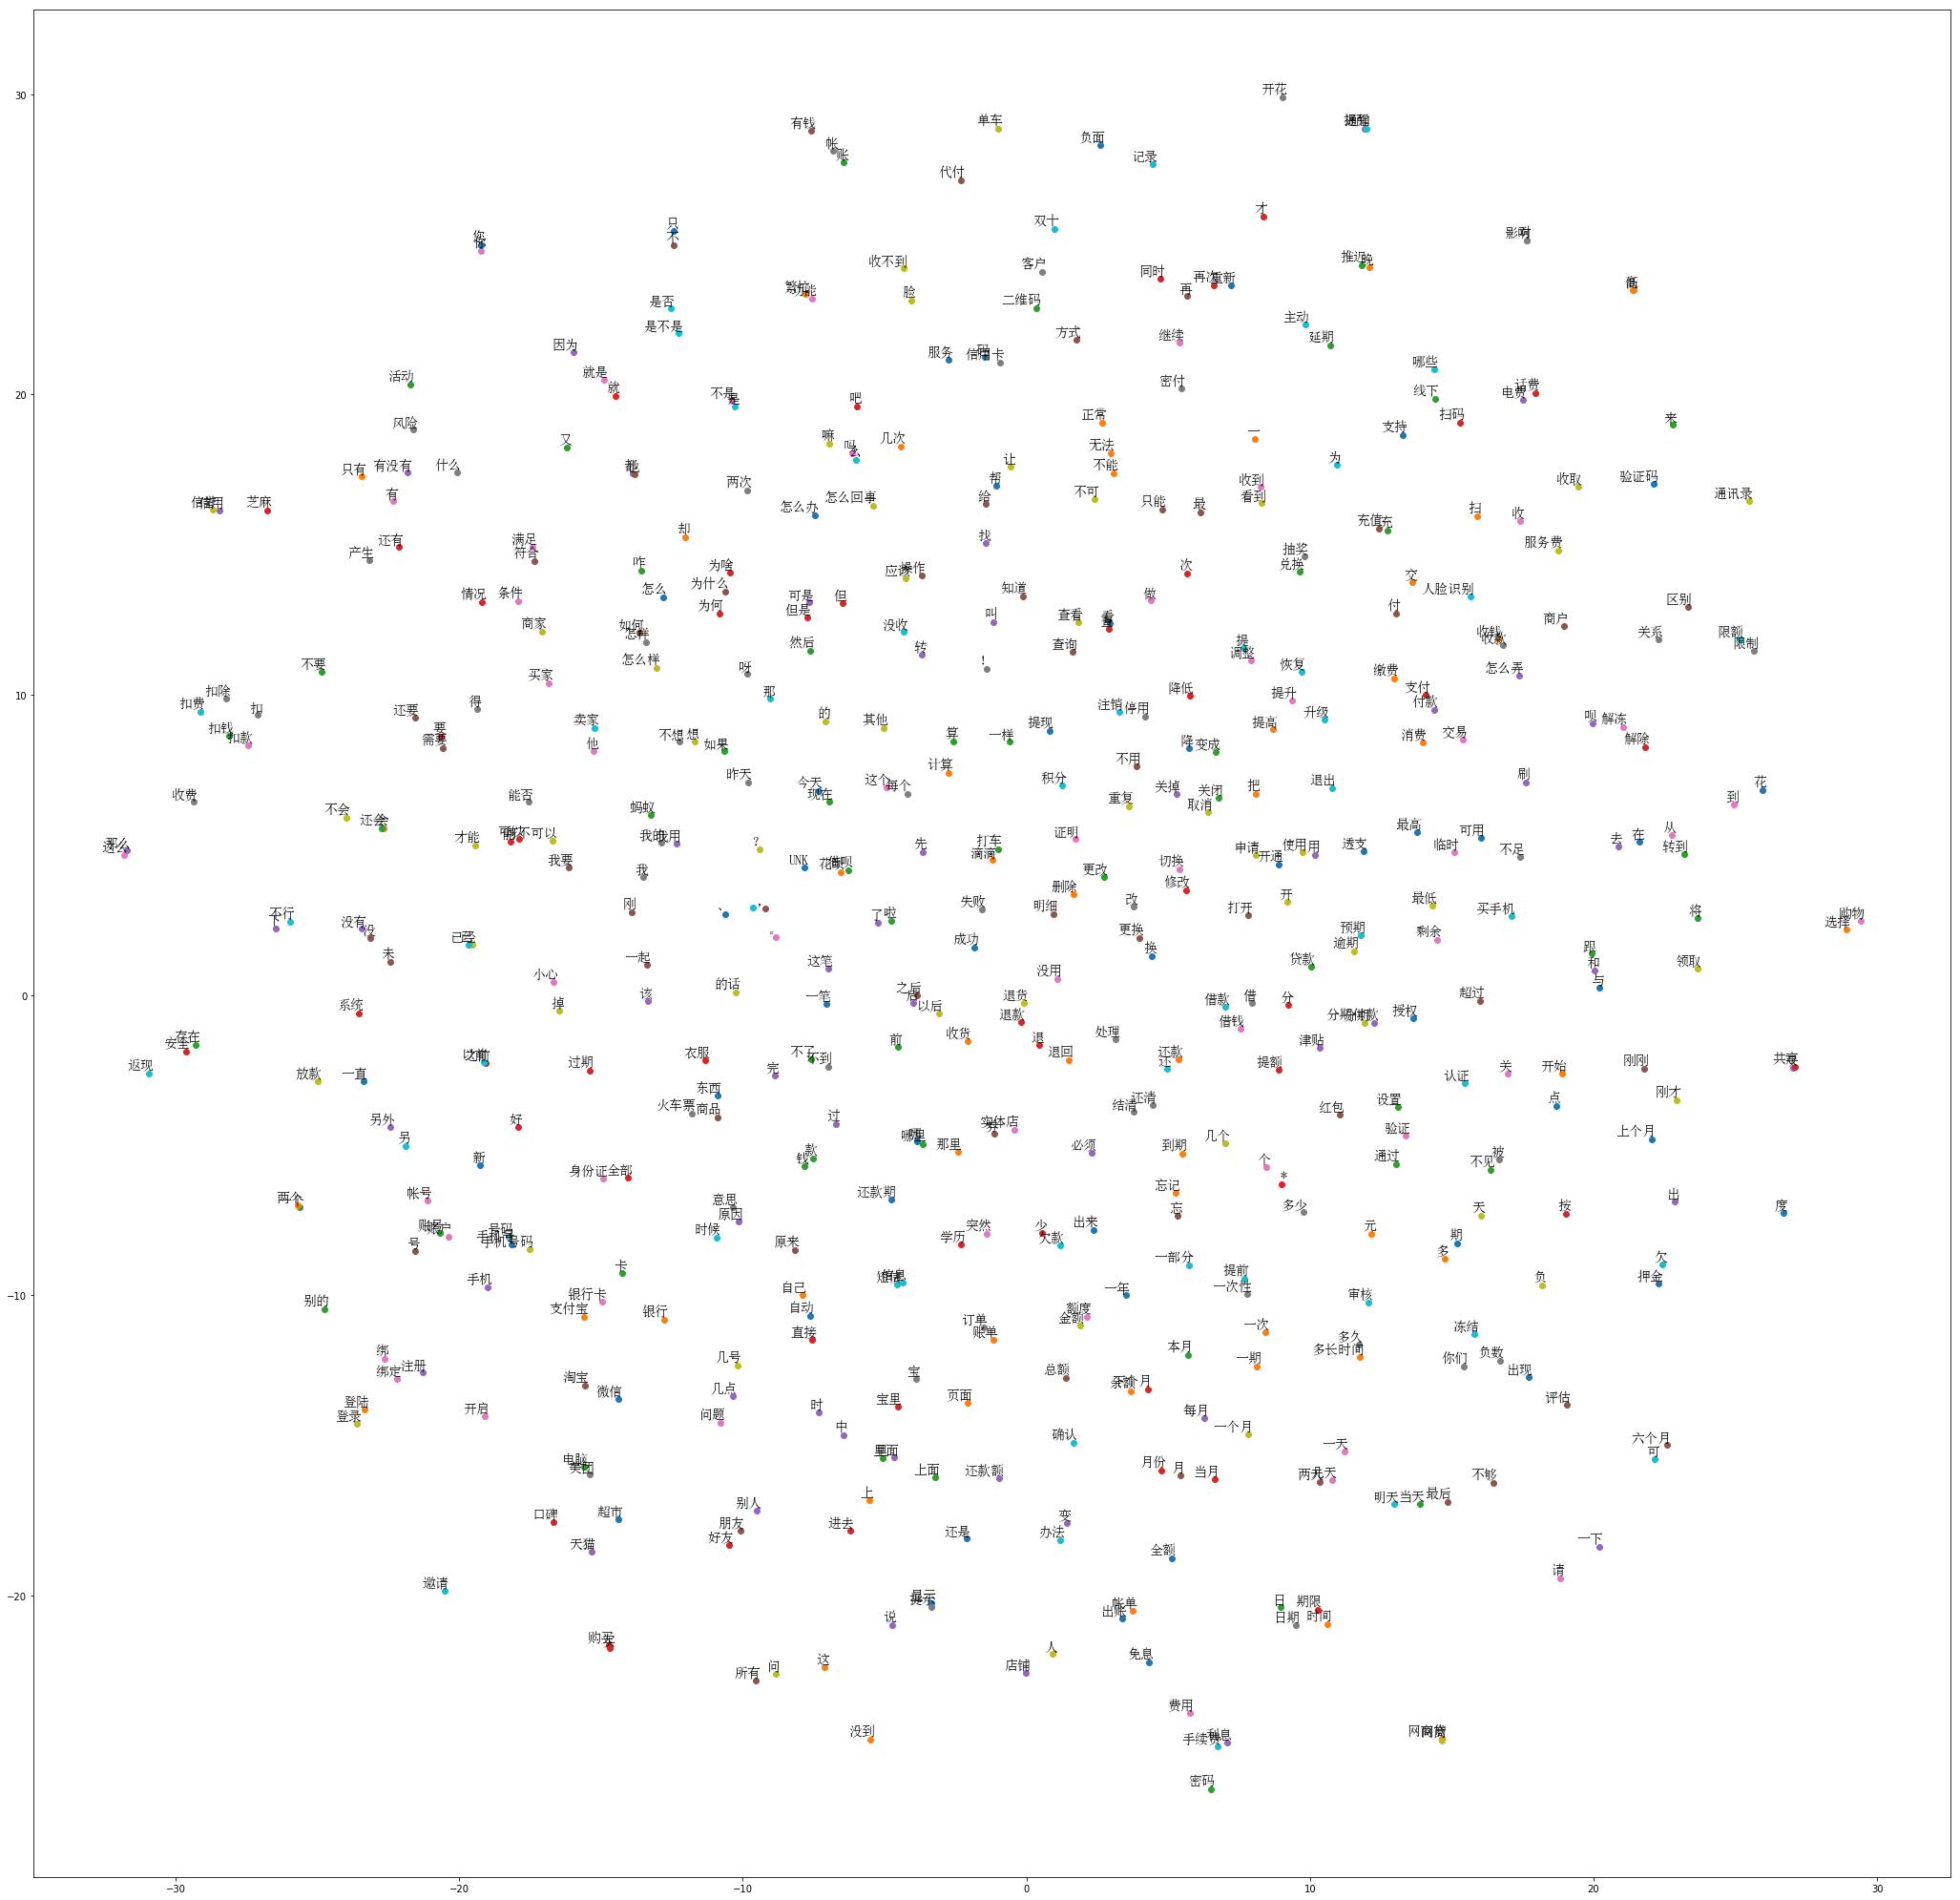

In [32]:
# Step 6: Visualize the embeddings.
def plot_with_labels(low_dim_embs, labels, filename='tsne.png',fonts=None):
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    plt.figure(figsize=(36, 36))  # in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)
        plt.annotate(label,
                    fontproperties=fonts,
                    xy=(x, y),
                    xytext=(5, 2),
                    textcoords='offset points',
                    ha='right',
                    va='bottom')
    plt.savefig(filename,dpi=600)
    
try:
    from sklearn.manifold import TSNE
    import matplotlib.pyplot as plt
    from matplotlib.font_manager import FontProperties
    
    # 为了在图片上能显示出中文
    font = FontProperties(fname=r"simsun.ttf", size=14)
    
    tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
    plot_only = 500
    low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])
    labels = [reverse_dictionary[i] for i in xrange(plot_only)]
    plot_with_labels(low_dim_embs, labels, fonts=font)
    
except ImportError:
    print("Please install sklearn, matplotlib, and scipy to visualize embeddings.")